In [45]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from multiprocessing import Pool
import pprintpp
pprintpp.monkeypatch() 

import re
from multiprocessing.pool import Pool
from collections import Counter
import itertools
import pickle
import json
from IPython.display import display as disp
from sklearn.tree import export_graphviz 
from sklearn.tree import DecisionTreeClassifier
import graphviz 
import subprocess

import numpy as np
# import bottleneck as bn
import pandas as pd
import networkx as nx
import igraph as ig
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.cm.rocket.set_bad([0.01060815, 0.01808215, 0.10018654])
mpl.cm.inferno.set_bad('k')
sns.set(context='paper', style='whitegrid', color_codes=True, font_scale=1.8)
colorcycle = [(0.498, 0.788, 0.498),
              (0.745, 0.682, 0.831),
              (0.992, 0.753, 0.525),
              (0.220, 0.424, 0.690),
              (0.749, 0.357, 0.090),
              (1.000, 1.000, 0.600),
              (0.941, 0.008, 0.498),
              (0.400, 0.400, 0.400)]
%matplotlib inline
sns.set_palette(colorcycle)

# import warnings
# warnings.simplefilter("ignore", category=DeprecationWarning)
# warnings.simplefilter("ignore", category=mpl.cbook.mplDeprecation)
# warnings.simplefilter("ignore", category=UserWarning)


from speclib import misc, loaders, graph, plotting

pd.set_option('display.max_rows', 55)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)
np.set_printoptions(linewidth=145)

mpl.rcParams['figure.max_open_warning'] = 65
mpl.rcParams['text.usetex'] = True 
mpl.rcParams['figure.figsize'] = [12, 7] 

# import pixiedust

/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/pprintpp/__init__.py:171: UserWarning: 'pprint' has already been imported; monkeypatching won't work everywhere.
  warnings.warn("'pprint' has already been imported; monkeypatching "


In [2]:
mpl.rcParams['figure.figsize'] = [12, 7] 

# Plot decision tree

Make a decision tree plot for the report

In [3]:
data_path = '../../allan_data/DataPredictMovement_half.p'
x, y = np.load(data_path)
x = x
xx_tr = x[:8000, :] 
yy_tr = y[:8000] 

In [5]:
with open('userMovement_rf_coarse.pkl', 'br') as fid:
    rfc = pickle.load(fid) 
with open('userMovement_rf_finer.pkl', 'br') as fid:
    rff = pickle.load(fid)

In [6]:
rfc.best_estimator_

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=16, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
     ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [7]:
rfc.validation_auc_score

0.8589634875117511

In [8]:
rfc.best_score_

0.8584558041362306

In [9]:
rfc.validation_auc_score - rfc.best_score_

0.0005076833755205401

In [10]:
est = rfc.best_estimator_.steps[1][1] 

In [11]:
est.feature_importances_.shape

(32,)

In [26]:
tr0 = est.estimators_[0] 

In [27]:
tr0 = est.estimators_[0]
columns = np.array([f"{cha}{qrt}" for cha in "CSGB" for qrt in range(1, 9)])
feature_importance = np.zeros((len(est.estimators_), len(tr0.feature_importances_)))
for i, tr in enumerate(est.estimators_):
    feature_importance[i, :] = tr.feature_importances_ 
fi = pd.DataFrame(feature_importance, columns=columns)
fi.columns.name = 'Communication channel'
fi.index.name = "Tree" 

In [28]:
fi = fi[fi.mean().sort_values(ascending=False).index] * 100

In [29]:
fi.head() 

Communication channel,B7,B3,G7,G3,S7,...,C6,S5,S1,C5,C1
Tree,,,,,,,,,,,
0,44.911739,35.679640,0.976231,1.277292,1.337043,...,0.254748,0.172246,0.279923,0.171319,0.181755
1,77.268876,2.934542,2.970511,0.707058,0.798130,...,0.249481,0.196723,0.159604,0.162971,0.181244
2,75.404045,4.641294,2.561013,2.451872,0.564517,...,0.298924,0.180989,0.173417,0.176871,0.152236
3,52.733662,33.823561,0.718640,1.674308,0.695750,...,0.220801,0.222329,0.176601,0.183128,0.201160
4,80.813430,3.792741,1.388992,2.500923,0.651349,...,0.198659,0.179466,0.188586,0.184450,0.172293


In [30]:
cat_dct = {'B': 0.0, 'C': 1.0, 'G': 2.0, 'S': 3.0} 
cat = pd.Series(fi.columns.str[0].map(lambda s: cat_dct[s]), index=fi.columns) 

In [34]:
fi_agg = pd.DataFrame([fi.mean(), fi.median(), fi.std(), cat],
                      index=['feature importance mean', 'feature importance median', 'std', 'cat']).T
fi_agg.head() 

,feature importance mean,feature importance median,std,cat
Communication channel,,,,
B7,60.635047,59.206065,15.640734,0.0
B3,14.030777,5.922327,12.831086,0.0
G7,5.376852,2.358156,5.762392,2.0
G3,3.488555,1.674308,4.171598,2.0
S7,1.740810,0.798130,2.083635,3.0


In [40]:
for i, tr in enumerate(est.estimators_):
    export_graphviz(tr, out_file=f'graphviz_files/tree_{i}.dot', feature_names=fi.columns,
                class_names=['move', 'still'], rounded=True, proportion=False,
                precision=4, filled=True, max_depth=4) 
    if i % 5 == 0:
        print(f"Done processing tree {i} of {len(est.estimators_)}")

Done processing tree 0 of 45
Done processing tree 5 of 45
Done processing tree 10 of 45
Done processing tree 15 of 45
Done processing tree 20 of 45
Done processing tree 25 of 45
Done processing tree 30 of 45
Done processing tree 35 of 45
Done processing tree 40 of 45


In [42]:
def compile_dot(dotfile, pngfile):
    subprocess.call(['dot', '-Tpng', dotfile, '-o', pngfile, '-Gdpi=450'])
    return None

In [46]:
pool = Pool(16)

asc = pool.starmap_async(compile_dot,
                   [(f'graphviz_files/tree_{i}.dot', f'graphviz_files/tree_{i}.png') for i in range(45)])

asc.get() 

pool.close() 

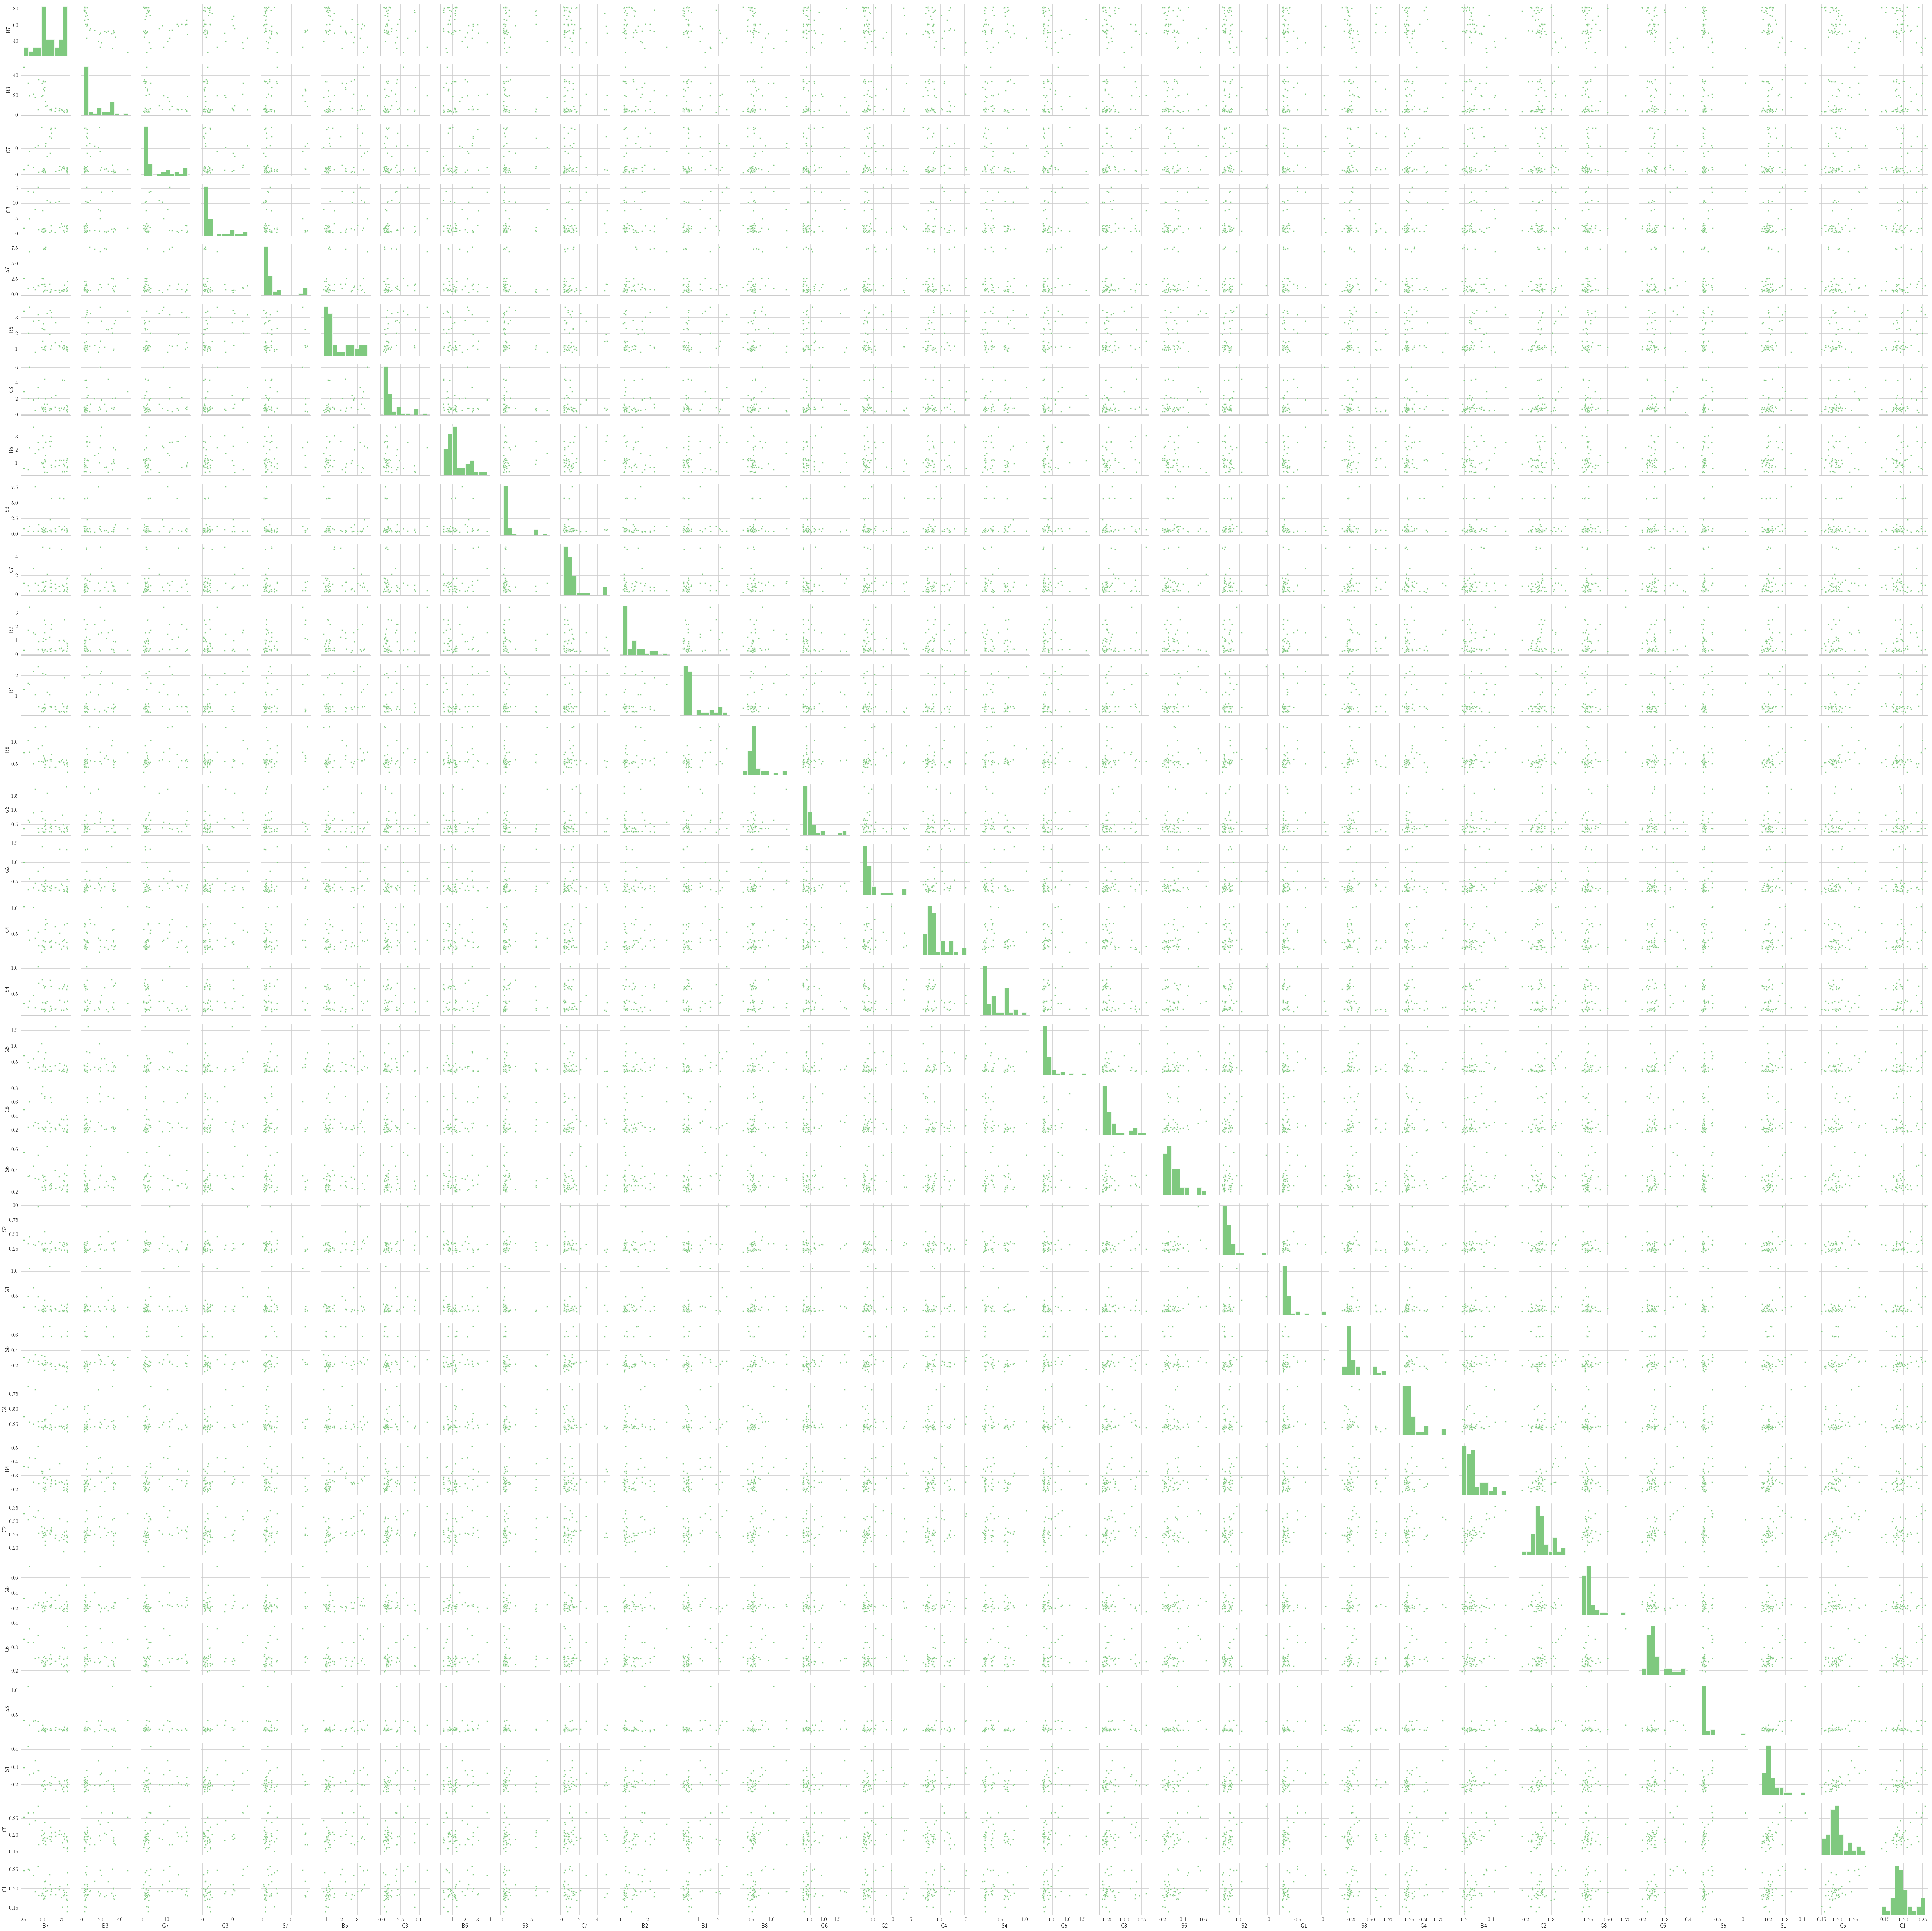

In [54]:
sns.pairplot(data=fi)

/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


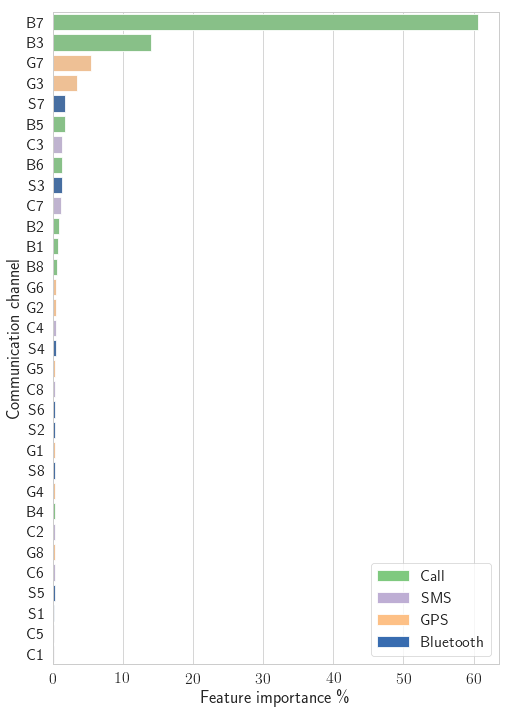

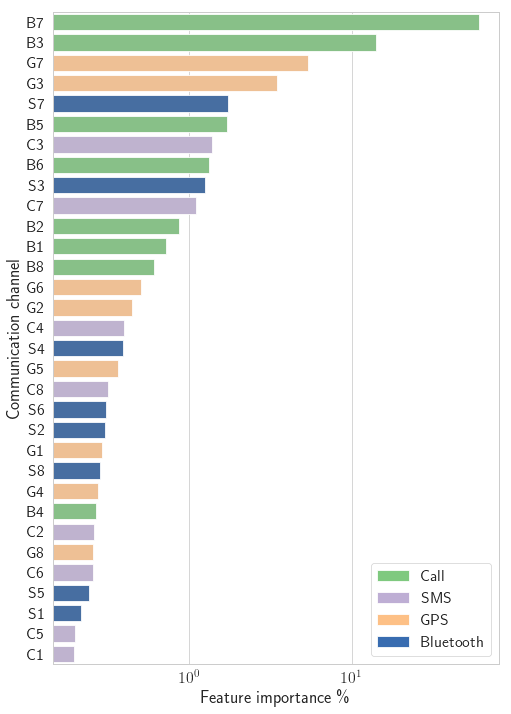

In [53]:
for log_switch in [False, True]:
    fig, ax = plt.subplots(figsize=(8, 12))
    bars = sns.barplot(data=fi_agg, x='Feature importance', y=fi_agg.index,
                       hue='cat', dodge=False, ax=ax, log=log_switch, orient='h')
    custom_lines = [mpl.patches.Patch(facecolor=colorcycle[0]),
                    mpl.patches.Patch(facecolor=colorcycle[1]), 
                    mpl.patches.Patch(facecolor=colorcycle[2]),
                    mpl.patches.Patch(facecolor=colorcycle[3])]
    ax.legend(custom_lines, ["Call", "SMS", "GPS", "Bluetooth"], loc="lower right")
    ax.set_xlabel('Feature importance \\%') 
    if log_switch:
        fig.savefig('figs/random_forest_important_features_logarithmic.pdf')
    else:
        fig.savefig('figs/random_forest_important_features_linear.pdf') 

In [56]:
fi_agg['Feature importance']

Communication channel
B7    60.635047
B3    14.030777
G7     5.376852
G3     3.488555
S7     1.740810
B5     1.709319
C3     1.372402
B6     1.332545
S3     1.246466
C7     1.102512
B2     0.869122
B1     0.719041
B8     0.606133
G6     0.502796
G2     0.445082
C4     0.396808
S4     0.393738
G5     0.362911
C8     0.317319
S6     0.305988
S2     0.303238
G1     0.291071
S8     0.284002
G4     0.274439
B4     0.267163
C2     0.261367
G8     0.255945
C6     0.255237
S5     0.243382
S1     0.214690
C5     0.199162
C1     0.196081
Name: Feature importance, dtype: float64

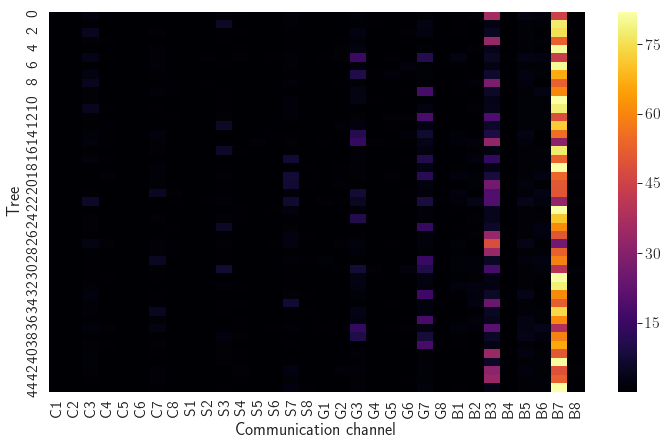

In [49]:
fig, ax = plt.subplots()
sns.heatmap(data=fi[columns], cmap='inferno') 

In [40]:
tr0.tree_.node_count

31331

In [41]:
n_tree_nodes = np.array([tr.tree_.node_count for tr in est.estimators_])

Text(0,0.5,'\\# trees')

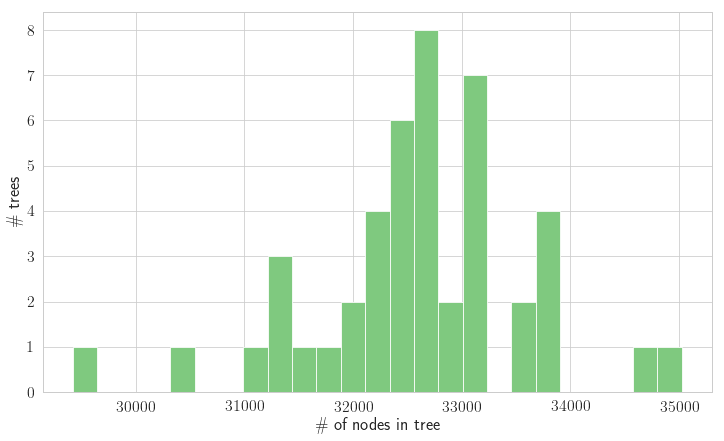

In [23]:
fig, ax = plt.subplots()
ax.hist(n_tree_nodes, 25)
ax.set_xlabel(r"\# of nodes in tree")
ax.set_ylabel(r"\# trees")

In [24]:
kw_rx = re.compile(r'(?P<key>\S+) = (?P<value>.+)')
op_rx = re.compile(r'(?P<key>\S+) (?P<operator>\S=) (?P<value>.+)')
ed_rx = re.compile(r'^(\d+) -> (\d+)') 

In [25]:
x_rx = re.compile(r'X\[(\d{1,2})\]')

def parse_label(label):
    m = x_rx.search(label)
    if m:
        return int(m.groups()[0]) 
    return None

In [26]:
def tree2nxgraph(tr):
    dot_file = export_graphviz(tr, out_file=None)
    nodes, edges = list(), list()
    for line in dot_file.split('\n'):
        try:
            if '[label=' in line:
                start = line.find('"') + 1
                end = line.find('"', start)
                lbl = line[start:end]
                nodes.append((int(line.split(' ', maxsplit=1)[0]), parse_label(lbl)))
                continue
            elif '->' in line:
                a, b = ed_rx.search(line).groups()
                edges.append((int(a), int(b)))
            else:
                # print("Didn't read", repr(line))
                pass
        except:  # noqa
            print(line)
    g = nx.DiGraph()
    for nid, attr in nodes:
        g.add_node(nid, nodeattr=attr)
    g.add_edges_from(edges)
    return g, nodes

In [27]:
def tree_stat_summary(g, nodes):
    outdeg_arr     = np.array(g.out_degree)
    outdeg_count   = pd.value_counts(outdeg_arr[:, 1])
    node_splits    = outdeg_arr[(outdeg_arr[:, 1] == 2), 0]
    dist_from_root = [nx.shortest_path_length(g, 0, nd) for nd in node_splits]


    nodeattr  = nx.get_node_attributes(g, 'nodeattr')
    splits    = np.array(nodes)[:, 1]
    splits_vc = pd.value_counts(splits, dropna=False)

    narr = np.array(nodes)
    narr_vc = pd.value_counts(narr[:, 1])

    root_distance = np.zeros((16, 32), dtype=int)
    rootdf = list()
    for i, (nd, sv) in enumerate(((nd, sv) for (nd, sv) in nodes if g.out_degree[nd] == 2)):
        dst = nx.shortest_path_length(g, 0, nd)
        root_distance[dst, sv] += 1
        rootdf.append((nd, sv, dst))
    rootdf = pd.DataFrame(rootdf, columns="node variable distance".split())
    return outdeg_count, dist_from_root, splits_vc, root_distance, rootdf


In [28]:
root_distance_agg = np.zeros((16, 32))
splits_vc_agg = pd.Series(index=list(range(32)) + [np.NaN])
dist_from_root_agg = list()
for tr in est.estimators_:
    g, nodes = tree2nxgraph(tr)
    
    outdeg_count, dist_from_root, splits_vc, root_distance, rootdf = tree_stat_summary(g, nodes) 
    
    root_distance_agg += root_distance
    splits_vc_agg += splits_vc 
    dist_from_root_agg.append(dist_from_root)

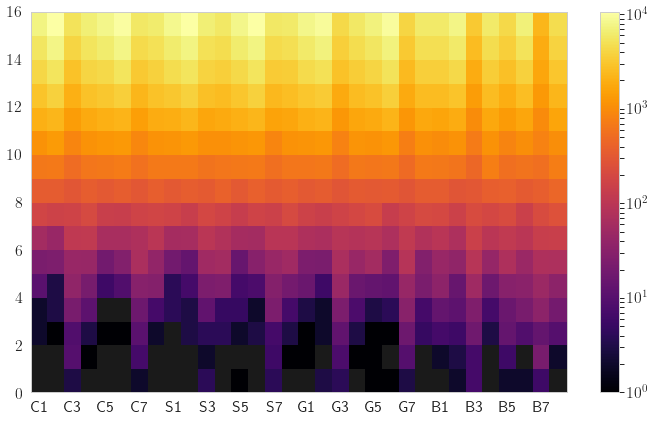

In [57]:
fig, ax = plt.subplots() 
data = root_distance_agg + 1
pc = ax.pcolor(root_distance_agg, norm=mpl.colors.LogNorm(), cmap='inferno')
fig.colorbar(pc)
xticks_incices = np.arange(0, 32, 2) 
ax.set_xticks(xticks_incices + 0.5)
ax.set_xticklabels([columns[i].upper() for i in xticks_incices]); 
fig.savefig('figs/festure_split_distance_from_root.pdf')

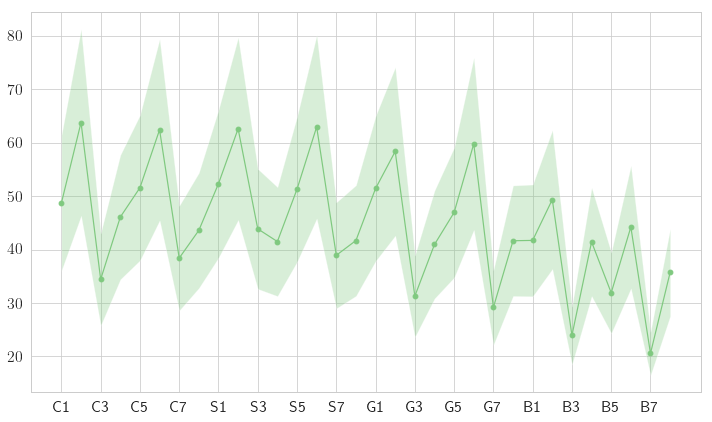

In [30]:
fig, ax = plt.subplots()
x = np.arange(root_distance_agg.shape[1])
y = root_distance_agg.mean(axis=0)/32
std = root_distance_agg.std(axis=0)/np.sqrt(32)/32
ax.fill_between(x, y-std, y+std, alpha=0.3)
ax.plot(x, y, '-o')
xticks_incices = np.arange(0, 32, 2) 
ax.set_xticks(xticks_incices)
ax.set_xticklabels([columns[i].upper() for i in xticks_incices])
fig.savefig('figs/mean_feature_split_distance_from_root.pdf')

In [31]:
def tree_stat_summary(g, nodes):
    outdeg_arr     = np.array(g.out_degree)
    outdeg_count   = pd.value_counts(outdeg_arr[:, 1])
    node_splits    = outdeg_arr[(outdeg_arr[:, 1] == 2), 0]
    dist_from_root = [nx.shortest_path_length(g, 0, nd) for nd in node_splits]


    nodeattr  = nx.get_node_attributes(g, 'nodeattr')
    splits    = np.array(nodes)[:, 1]
    splits_vc = pd.value_counts(splits, dropna=False)

    narr = np.array(nodes)
    narr_vc = pd.value_counts(narr[:, 1])

    root_distance = np.zeros((16, 32), dtype=int)
    rootdf = list()
    for i, (nd, sv) in enumerate(((nd, sv) for (nd, sv) in nodes if g.out_degree[nd] == 2)):
        dst = nx.shortest_path_length(g, 0, nd)
        root_distance[dst, sv] += 1
        rootdf.append((nd, sv, dst))
    rootdf = pd.DataFrame(rootdf, columns="node variable distance".split())
    return outdeg_count, dist_from_root, splits_vc, root_distance, rootdf


outdeg_count, dist_from_root, splits_vc, root_distance, rootdf = tree_stat_summary(g, nodes) 

In [32]:
print(outdeg_count) 

0    14712
2    14711
dtype: int64


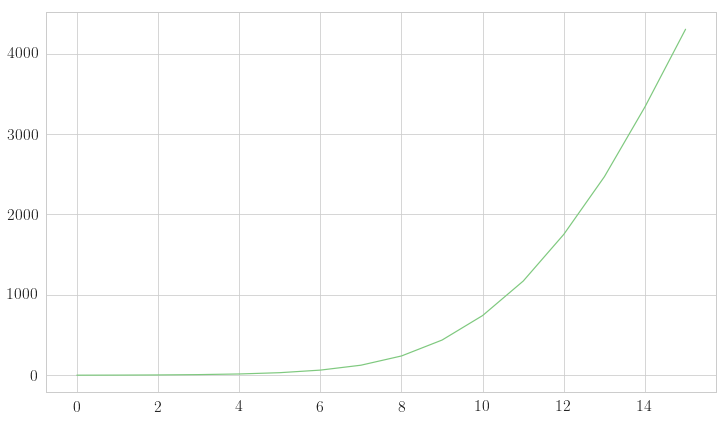

In [33]:
fig, ax = plt.subplots()
plt.plot(pd.value_counts(dist_from_root)[::-1]) 

In [34]:
print(splits_vc)

NaN      14712
 9.0       702
 17.0      696
 1.0       649
 5.0       636
 13.0      636
 21.0      603
 25.0      602
 8.0       576
 12.0      559
 16.0      524
 2.0       514
 3.0       513
 6.0       511
 0.0       501
 20.0      495
 4.0       473
 11.0      464
 27.0      458
 10.0      453
 15.0      428
 22.0      428
 23.0      427
 31.0      426
 24.0      414
 29.0      409
 7.0       382
 26.0      367
 28.0      303
 19.0      256
 18.0      180
 14.0      125
 30.0        1
dtype: int64


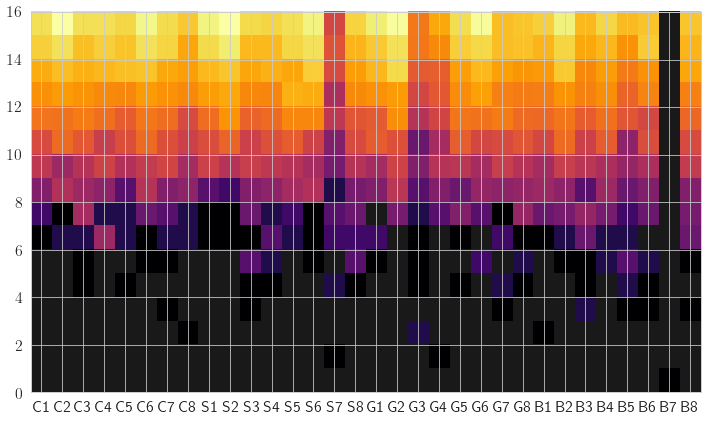

In [68]:
fig, ax = plt.subplots()
ax.pcolorfast(root_distance, norm=mpl.colors.LogNorm(), cmap='inferno') 
ax.set_xticks(np.arange(32) + 0.5)
ax.set_xticklabels(columns); 

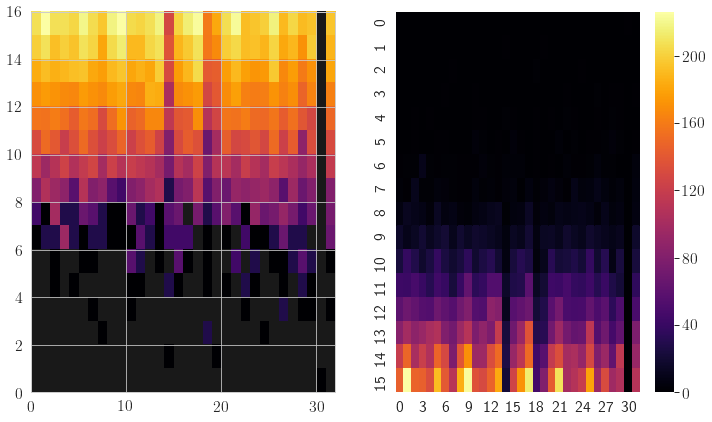

In [71]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.pcolorfast(root_distance, norm=mpl.colors.LogNorm(), cmap='inferno') 
# ax1.set_xticks(np.arange(32) + 0.5)
# ax1.set_xticklabels(columns); 

sns.heatmap(data=root_distance, cmap='inferno') 
# ax2.set_xticks(np.arange(32) + 0.5)
# ax2.set_xticklabels(columns); 

In [36]:
x.shape, y.shape

((32,), (32,))

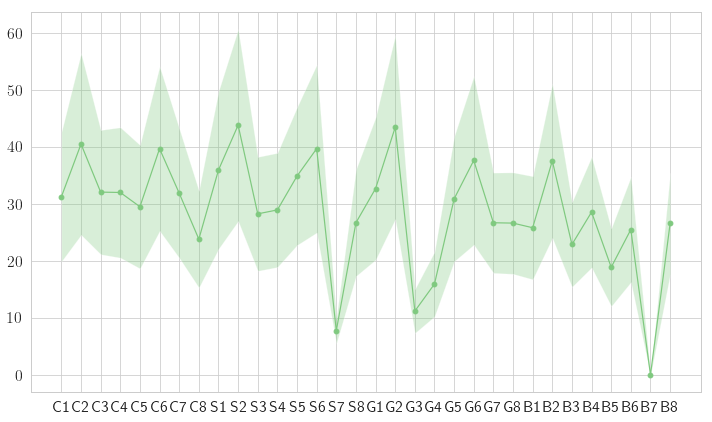

In [37]:
fig, ax = plt.subplots()
x = np.arange(root_distance.shape[1])
y = root_distance.mean(axis=0)
std = root_distance.std(axis=0)/np.sqrt(root_distance.shape[0])
ax.fill_between(x, y-std, y+std, alpha=0.3)
ax.plot(x, y, '-o')
ax.set_xticks(np.arange(32))
ax.set_xticklabels(columns); 